<a href="https://colab.research.google.com/github/lmei33/trial/blob/master/HW_7_Anime_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anime Recommendations


## Data Preprocessing

### Import Data

In [0]:
!pip install -q scikit-surprise

    100% |████████████████████████████████| 3.3MB 6.7MB/s 


In [0]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset,Reader,SVD, evaluate
sns.set_style("darkgrid")

In [0]:
from google.colab import files

In [0]:
uploaded = files.upload()

Saving anime.csv to anime.csv


In [0]:
uploaded = files.upload()

In [0]:
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

In [0]:
rating = rating[rating.rating>0]
rating = rating.reset_index()
rating.drop('index', axis=1,inplace=True)
rating.head()

,user_id,anime_id,rating
0,1,8074,10
1,1,11617,10
2,1,11757,10
3,1,15451,10
4,2,11771,10


### Overview of rating

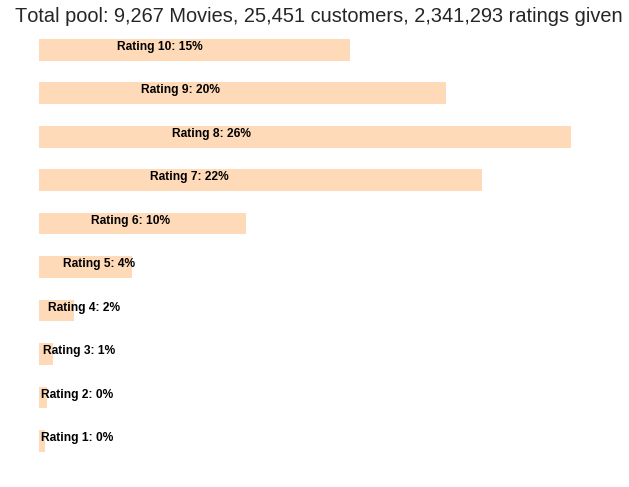

In [0]:
p = rating.groupby(['rating']).agg(['count'])
p.drop(p.columns[1], axis=1,inplace=True)

# get anime count
anime_count = rating['anime_id'].nunique()

# get customer count
cust_count = rating['user_id'].nunique()

# get rating count
rating_count = rating['user_id'].count()

ax = p.plot(kind = 'barh', legend = False, figsize = (10,8),color='peachpuff')
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(anime_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,11):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'black', weight = 'bold')

In [0]:
rating_p = pd.pivot_table(rating,values='rating',index='user_id',columns='anime_id')

In [0]:
rating_p.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34103,34107,34136,34238,34240,34283,34324,34325,34349,34475
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,8.0,NaN,NaN,6.0,NaN,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Mapping table

In [0]:
anime_mapping = anime.copy()
anime_mapping.drop(['episodes','members','rating'],axis=1, inplace=True)
#anime_mapping.set_index('anime_id',inplace=True)

In [0]:
anime_mapping.head()

,anime_id,name,genre,type
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV


## Collaborative Filtering Recommendation Exploration


In [0]:
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(rating[['user_id', 'anime_id', 'rating']], reader)

In [0]:
from surprise import Dataset, print_perf
from surprise.model_selection import cross_validate

In [0]:
#data = Dataset.load_from_df(rating, reader)
data = Dataset.load_from_df(rating[['user_id', 'anime_id', 'rating']], reader)
data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 1.1752
MAE:  0.8824
------------
Fold 2
RMSE: 1.1741
MAE:  0.8819
------------
Fold 3
RMSE: 1.1752
MAE:  0.8831
------------
------------
Mean RMSE: 1.1749
Mean MAE : 0.8824
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.8823862875167051,
                             0.8818889550866091,
                             0.8830618701373266],
                            'rmse': [1.1751973987860223,
                             1.1741269965635912,
                             1.175244614477035]})

### An example

In [0]:
rating.iloc[3303,:]

user_id       45
anime_id    1498
rating         8
Name: 3303, dtype: int64

In [0]:
user_45 = rating[(rating['user_id'] == 45) & (rating['rating'] > 8)]
#user_45 = user_45.set_index('anime_id')
user_45 = user_45.merge(anime_mapping, how="inner", on="anime_id")

In [0]:
print("What user_45 liked in the past:")
user_45.head(10)

What user_45 liked in the past:


,user_id,anime_id,rating,name,genre,type
0,45,853,10,Ouran Koukou Host Club,"Comedy, Harem, Romance, School, Shoujo",TV
1,45,1571,9,Ghost Hunt,"Comedy, Horror, Mystery, Shoujo, Supernatural",TV
2,45,3457,9,Vampire Knight,"Drama, Mystery, Romance, Shoujo, Supernatural,...",TV
3,45,4722,9,Skip Beat!,"Comedy, Drama, Romance, Shoujo",TV
4,45,6547,10,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV
5,45,7054,10,Kaichou wa Maid-sama!,"Comedy, Romance, School, Shoujo",TV
6,45,10800,9,Chihayafuru,"Drama, Game, Josei, Slice of Life, Sports",TV
7,45,11111,9,Another,"Horror, Mystery, School, Supernatural, Thriller",TV
8,45,11757,9,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV


In [0]:
print(svd.predict(45, 10800, 9))

user: 45         item: 10800      r_ui = 9.00   est = 8.36   {'was_impossible': False}


In [0]:
user_45 = anime_mapping.copy()

trainset = data.build_full_trainset()
svd.train(trainset)

user_45['Estimate_Score'] = user_45['anime_id'].apply(lambda x: svd.predict(45, x).est)

user_45 = user_45.drop('anime_id', axis = 1)

user_45 = user_45.sort_values('Estimate_Score', ascending=False)

In [0]:
user_45.head(10)

,name,genre,type,Estimate_Score
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.564312
164,Ouran Koukou Host Club,"Comedy, Harem, Romance, School, Shoujo",TV,9.469326
8,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,9.462168
35,Howl no Ugoku Shiro,"Adventure, Drama, Fantasy, Romance",Movie,9.451553
159,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,9.418476
409,There She Is!!,"Comedy, Romance",ONA,9.373343
15,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie,9.367663
410,xxxHOLiC,"Comedy, Drama, Mystery, Psychological, Superna...",TV,9.291806
7,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,9.289500
9,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.285289
